# Análise Exploratória de Dados (EDA)

## Monitoramento do Uso dos Terminais de Pagamento 

Este notebook apresenta uma Análise Exploratória de Dados (EDA) realizada com o objetivo de compreender o comportamento do parque de terminais de pagamento de uma empresa, considerando três dimensões principais: a estrutura instalada dos terminais, o uso por meio das transações realizadas e a qualidade operacional representada pelos chamados técnicos.

Os dados utilizados neste estudo foram criados de forma sintética e representam um cenário real de operação. A EDA tem como finalidade identificar padrões, relações e métricas relevantes que subsidiem a construção de um dashboard de monitoramento e a definição de regras de observabilidade para o parque de terminais.

## Descrição das Bases de Dados

A análise foi conduzida a partir de três tabelas principais, cada uma com granularidade distinta e papel específico no entendimento do negócio:

- **tb_parque_terminais**: contém informações estruturais sobre os terminais instalados, incluindo identificadores do terminal e do cliente, segmento e setor do cliente, modelo do terminal e data de registro da instalação. Cada linha representa um terminal instalado.

- **tb_transacoes**: registra as transações realizadas nos terminais, incluindo data da transação, status, valor financeiro, tipo de transação e os identificadores do terminal e do cliente. Cada linha representa uma transação individual.

- **tb_chamados**: contém informações sobre os chamados técnicos abertos para os terminais, incluindo tipo e motivo do chamado, datas de abertura e fechamento, além dos identificadores do terminal e do cliente. Cada linha representa um chamado técnico.

Essas tabelas se relacionam principalmente por meio do identificador do terminal (`id_terminal`), permitindo análises integradas entre estrutura, uso e qualidade operacional.

In [2]:
# importações

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")

DATA_DIR = "/home/rusch/Área de trabalho/Projeto_Cielo/Desafio2/dados"

## Leitura e Preparação dos Dados

Inicialmente, os arquivos CSV foram carregados para o ambiente de análise. Em seguida, foi realizada a conversão das colunas de data para o formato adequado (`datetime`), garantindo consistência temporal para as análises subsequentes.

Essa etapa é fundamental para possibilitar análises de séries temporais, cálculo de tempos de resolução de chamados e identificação de períodos de inatividade dos terminais.

In [3]:
tb_parque = pd.read_csv(                                 # abre, interpreta seu conteúdo e converte o arquivo em um objeto do tipo DataFrame
    os.path.join(DATA_DIR, "tb_parque_terminais.csv"),   # O caminho completo até o arquivo
    parse_dates=["data_registro"]                        # instrui explicitamente o pandas a interpretar a coluna data_registro como um tipo 
)                                                        # de dado temporal (datetime), e não como uma simples string)

tb_transacoes = pd.read_csv(
    os.path.join(DATA_DIR, "tb_transacoes.csv"),
    parse_dates=["data_transacao"]
)

tb_chamados = pd.read_csv(
    os.path.join(DATA_DIR, "tb_chamados.csv"),
    parse_dates=["data_abertura_chamado", "data_fechamento_chamado"]
)

## Validação de Qualidade e Consistência dos Dados

Antes de avançar para análises mais aprofundadas, foi realizada uma verificação de consistência relacional entre as tabelas. Essa validação teve como objetivo garantir que as transações e os chamados técnicos estivessem corretamente associados a terminais existentes no parque. Os resultados indicaram alta consistência entre as bases, permitindo prosseguir com segurança para análises relacionais e cálculo de métricas integradas.

# 1. Inspeção inicial dos dados (Sanidade)

In [53]:
tb_parque.head()

,id_terminal,id_cliente,segmento_cliente,setor_cliente,modelo,data_registro
0,61452592-8,1433629994664509,Empreendedores,Postos de Gasolina,L300,2024-02-27
1,73832068-0,5869507321464493,Varejistas,Restaurantes,S920,2021-02-19
2,75736846-9,46358068828503,Grandes contas,Restaurantes,ME60,2022-05-14
3,23368436-6,1354741685573952,Empreendedores,Farmacias,ME60,2022-02-10
4,70980810-3,5383388487920698,Empreendedores,Farmacias,ME60,2024-08-19


In [4]:
tb_transacoes.head()

,id_terminal,id_cliente,data_transacao,status_transacao,valor_transacao,tipo_transacao
0,27472941-2,6958050450509284,2022-02-24,OK,4403.44,CREDITO
1,64164841-7,3765456284177225,2025-05-12,OK,655.37,DEBITO
2,35152165-9,5932572287032200,2025-03-18,OK,6926.19,DEBITO
3,10352830-8,2909304376613662,2024-10-27,OK,95711.10,CREDITO
4,66706653-6,411761421524831,2025-09-19,OK,491.54,PIX


In [5]:
tb_chamados.head()

,id_chamado,id_terminal,id_cliente,tipo_chamado,motivo_chamado,data_abertura_chamado,data_fechamento_chamado
0,257750510,33300187-5,5291876831608271,MANUTENCAO,PROBLEMA NA BATERIA,2024-07-15,2024-07-21
1,573624925,57905434-3,9136964804073730,MANUTENCAO,PROBLEMA COM CONEXAO,2024-11-30,2024-12-01
2,372901889,78180379-8,7970623972652735,MANUTENCAO,PROBLEMA NA TELA,2025-09-05,2025-09-09
3,167819297,20662607-7,4907938841368528,MANUTENCAO,OUTROS,2025-05-16,2025-05-18
4,290388026,55617225-8,2234232161107603,MANUTENCAO,OUTROS,2023-09-20,2023-09-22


In [6]:
tb_parque.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id_terminal       5000 non-null   object        
 1   id_cliente        5000 non-null   int64         
 2   segmento_cliente  5000 non-null   object        
 3   setor_cliente     5000 non-null   object        
 4   modelo            5000 non-null   object        
 5   data_registro     5000 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 234.5+ KB


In [57]:
tb_transacoes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   id_terminal       100000 non-null  object        
 1   id_cliente        100000 non-null  int64         
 2   data_transacao    100000 non-null  datetime64[ns]
 3   status_transacao  100000 non-null  object        
 4   valor_transacao   100000 non-null  float64       
 5   tipo_transacao    100000 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 4.6+ MB


In [7]:
tb_chamados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   id_chamado               10000 non-null  int64         
 1   id_terminal              10000 non-null  object        
 2   id_cliente               10000 non-null  int64         
 3   tipo_chamado             10000 non-null  object        
 4   motivo_chamado           10000 non-null  object        
 5   data_abertura_chamado    10000 non-null  datetime64[ns]
 6   data_fechamento_chamado  10000 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 547.0+ KB


In [9]:
# Percentual de transações com terminal válido
tx_validas = tb_transacoes["id_terminal"].isin(tb_parque["id_terminal"]).mean() * 100

# Percentual de chamados com terminal válido
ch_validos = tb_chamados["id_terminal"].isin(tb_parque["id_terminal"]).mean() * 100

print(tx_validas.round(2), ch_validos.round(2))

100.0 100.0


A linha de código, `tx_validas = tb_transacoes["id_terminal"].isin(tb_parque["id_terminal"]).mean() * 100`, tem como finalidade quantificar, em termos percentuais, o grau de aderência entre **duas bases de dados distintas**, verificando se os registros de **transações** estão associados a terminais que efetivamente constam no **parque de terminais** cadastrado.

Do ponto de vista operacional, o código parte do DataFrame `tb_transacoes` e seleciona a coluna `id_terminal`, que identifica o terminal responsável por cada transação registrada. Em seguida, o método `.isin(tb_parque["id_terminal"])` é aplicado, realizando uma verificação elemento a elemento: para cada transação, o pandas avalia se o identificador do terminal associado a ela existe na coluna `id_terminal` do DataFrame `tb_parque`, que representa o cadastro oficial dos terminais ativos ou registrados.

O resultado dessa operação é uma série booleana, composta por valores `True` e `False`. Cada `True` indica que a transação está vinculada a um terminal válido (presente no parque), enquanto cada `False` sinaliza uma inconsistência, isto é, uma transação associada a um terminal inexistente ou não cadastrado na base de referência.

O resultado final, armazenado na variável `tx_validas`, representa o percentual de transações cuja integridade referencial é preservada, ou seja, **transações que fazem referência a terminais efetivamente existentes no parque**. Essa métrica é particularmente relevante em contextos de qualidade de dados, auditoria operacional e monitoramento de confiabilidade entre sistemas transacionais e cadastros mestres.

# 2. EDA da tabela tb_parque_terminais

## Análise Inicial da Estrutura do Parque de Terminais

A primeira etapa da EDA concentrou-se na compreensão da composição do parque de terminais. Foram analisadas a distribuição dos modelos de terminais, bem como a segmentação dos clientes por setor econômico e porte.

Essa análise fornece uma visão geral da base instalada, permitindo identificar quais modelos e perfis de clientes concentram maior presença no parque, o que é essencial para priorização de análises e definição de métricas estratégicas.

## 2.1 Distribuição dos modelos de terminais

In [10]:
(tb_parque["modelo"].value_counts(normalize=True) * 100).round(2)

modelo
ME60      12.68
L400      12.68
S920C     12.64
LIO V3    12.62
L300      12.54
D195      12.52
S920      12.24
SP930     12.08
Name: proportion, dtype: float64

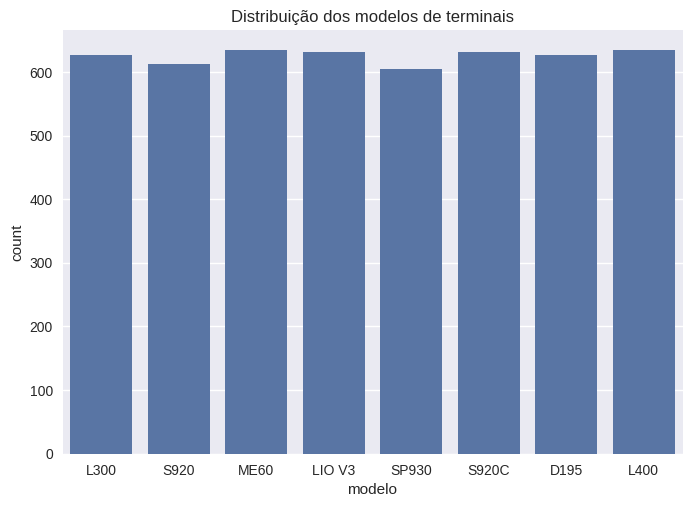

In [11]:
sns.countplot(data=tb_parque, x="modelo")
plt.title("Distribuição dos modelos de terminais")
plt.show()

**Insight esperado**: Identificar modelos predominantes → maior impacto operacional e financeiro.

## 2.2 Distribuição por segmento e setor

In [13]:
distrib_segmento_setor = pd.crosstab(
    tb_parque["segmento_cliente"], # linhas da tabela de contigência
    tb_parque["setor_cliente"],    # colunas da tabela de contigência
    normalize="index"
) * 100

(distrib_segmento_setor).round(2)

setor_cliente,Automotivos,Farmacias,Mercados,Padarias,Postos de Gasolina,Restaurantes,Shoppings,Tecnologia
segmento_cliente,,,,,,,,
Empreendedores,14.23,13.16,13.58,10.96,12.75,12.09,11.44,11.79
Grandes contas,11.27,11.58,12.56,12.87,12.50,13.85,13.05,12.32
Varejistas,11.84,12.91,12.20,12.85,12.73,12.20,13.20,12.08


**Insight**: Base para filtros estratégicos no dashboard e análise de comportamento por perfil de cliente.

A função `pd.crosstab` é utilizada para construir uma tabela de contingência, isto é, uma matriz que cruza duas variáveis categóricas. No caso específico, as linhas da tabela são definidas pela coluna `segmento_cliente`, enquanto as colunas correspondem à variável `setor_cliente`. Cada célula da tabela representa a frequência com que um determinado setor aparece dentro de um segmento específico.

O parâmetro `normalize="index"` altera o comportamento padrão da contagem absoluta. Em vez de retornar o número bruto de ocorrências, o pandas normaliza os valores ao longo do eixo das linhas. Isso significa que, para cada segmento de cliente, os valores das diferentes categorias de setor são divididos pelo total de registros daquele segmento, **produzindo proporções que somam 1 em cada linha**.

Após a normalização, a multiplicação por 100 converte essas proporções em percentuais, facilitando a interpretação e a comunicação dos resultados. O DataFrame resultante, armazenado na variável distrib_segmento_setor, passa a expressar, para cada segmento de cliente, qual é a participação percentual de cada setor de atuação.

Essa estrutura é particularmente útil para **análises de perfilização e segmentação**, permitindo identificar padrões como concentração setorial, diversificação ou especialização de determinados segmentos de clientes. Além disso, esse tipo de métrica é frequentemente empregado em relatórios gerenciais, dashboards estratégicos e estudos de mercado que buscam alinhar produtos, serviços ou políticas comerciais às características predominantes da base de clientes.

## 2.3  Análise Inicial do Uso dos Terminais

Na sequência, foram exploradas as informações relacionadas às transações realizadas nos terminais. Essa etapa teve como foco compreender o volume, o valor e o status das transações, buscando identificar padrões de uso e possíveis sinais de anomalias operacionais.

A análise do valor das transações evidenciou distribuições assimétricas, típicas de dados financeiros, reforçando a necessidade de métricas robustas para monitoramento do uso dos terminais.

### 2.3.1 Status das transações

In [68]:
status_trasacoes = tb_transacoes["status_transacao"].value_counts(normalize=True) * 100

status_trasacoes.round(2)

status_transacao
OK           69.99
CANCELADA    20.06
TIMEOUT       9.95
Name: proportion, dtype: float64

**Insight:** Taxas de falha ou cancelamento acima do esperado são sinal claro de problema técnico ou operacional.

### 2.3.2 Valor das transações

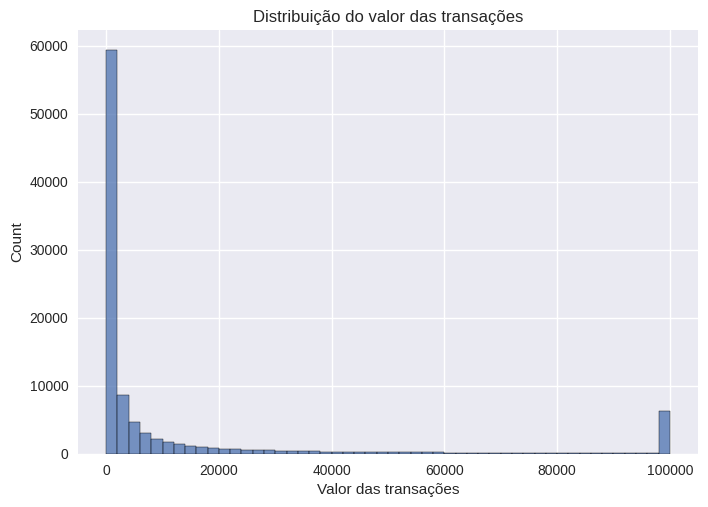

In [14]:
sns.histplot(tb_transacoes["valor_transacao"], bins=50)
plt.title("Distribuição do valor das transações")
plt.xlabel("Valor das transações")
plt.show()

## 2.4 Análise Inicial da Qualidade Operacional (Chamados Técnicos)

Por fim, foram analisados os dados de chamados técnicos com o objetivo de avaliar a qualidade operacional dos terminais. Foram exploradas as distribuições dos tipos de chamados e os tempos de resolução, permitindo identificar categorias de problemas mais frequentes e potenciais impactos no nível de serviço.

Essas análises iniciais fornecem subsídios para a definição de métricas de SLA e para a proposição de regras de observabilidade e alertas automáticos.

### 2.4.1 Tipos e motivos de chamados

In [70]:
(tb_chamados["tipo_chamado"].value_counts(normalize=True) * 100).round(2)

tipo_chamado
MANUTENCAO    72.4
SUPORTE       27.6
Name: proportion, dtype: float64

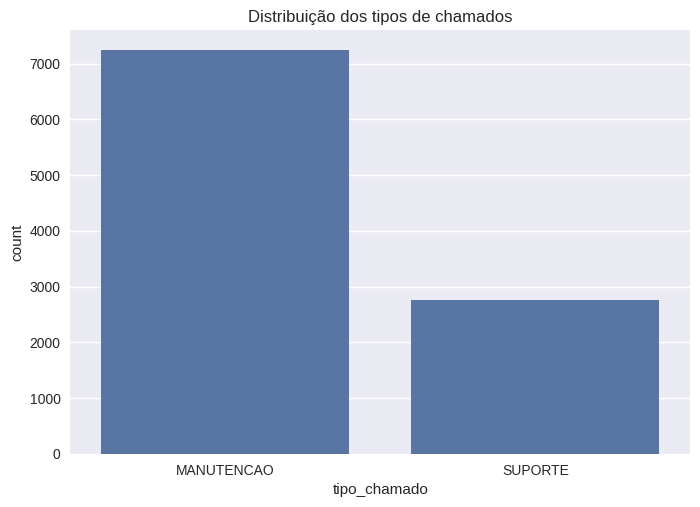

In [15]:
sns.countplot(data=tb_chamados, x="tipo_chamado")
plt.title("Distribuição dos tipos de chamados")
plt.show()

### 2.4.2 Tempo de resolução do Service Level Agreements (SLA) 

In [17]:
tb_chamados["tempo_resolucao_dias"] = (
    tb_chamados["data_fechamento_chamado"] -
    tb_chamados["data_abertura_chamado"]
).dt.days

As linhas de código acima tem como finalidade calcular o tempo de resolução de cada chamado, expresso em dias, e incorporá-lo explicitamente como uma nova variável analítica na base de dados `tb_chamados`.

Essa variável é particularmente relevante para análises de eficiência e qualidade de serviço, pois permite calcular indicadores como tempo médio de resolução, distribuição de prazos, identificação de chamados críticos ou atrasados e comparação de desempenho entre diferentes tipos de ocorrência, equipes ou períodos. Em contextos corporativos, métricas desse tipo são frequentemente utilizadas para monitorar **SLAs** (`Service Level Agreements`), subsidiar decisões gerenciais e alimentar dashboards operacionais.

In [18]:
tb_chamados["tempo_resolucao_dias"].describe()

count    10000.000000
mean         3.780500
std          3.325632
min          1.000000
25%          2.000000
50%          3.000000
75%          5.000000
max         62.000000
Name: tempo_resolucao_dias, dtype: float64

**Insight**: Chamados com alto tempo de resolução são candidatos diretos a métricas de SLA e alertas automáticos.

## Síntese da Etapa Inicial da EDA

A etapa inicial da Análise Exploratória de Dados permitiu compreender a estrutura das bases, validar a consistência dos dados e identificar padrões preliminares relacionados à composição do parque, ao uso dos terminais e à qualidade operacional.

Com essa base estabelecida, as próximas etapas da EDA se concentrarão em análises relacionais entre modelos de terminais, volume de transações e chamados técnicos, culminando na definição de métricas estratégicas para o dashboard de monitoramento.

# Análise Exploratória dos Dados

# Qual a distribuição dos modelos de terminais?

## Distribuição dos Modelos de Terminais

A primeira análise exploratória tem como objetivo compreender a composição do parque de terminais da Cielo em termos dos modelos instalados. Essa informação é fundamental, pois os modelos representam diferentes gerações tecnológicas de hardware, que podem impactar diretamente o desempenho operacional, a frequência de chamados técnicos e o volume de transações processadas.

Ao identificar a distribuição dos modelos, é possível compreender quais tecnologias são predominantes no parque e quais concentram maior potencial de impacto sobre a operação como um todo.

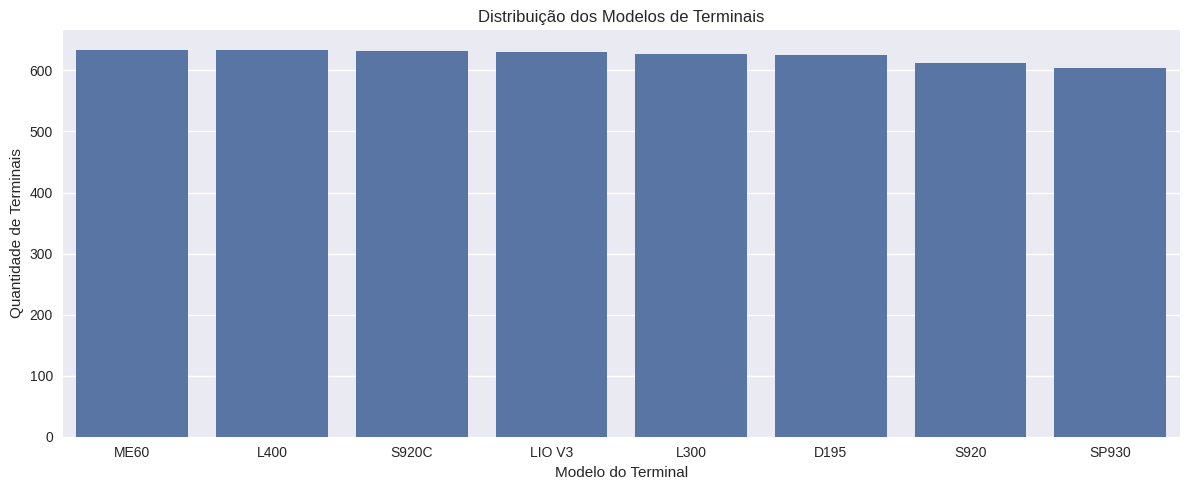

In [19]:
plt.figure(figsize=(12, 5))
sns.countplot(
    data=tb_parque,
    x="modelo",
    order=tb_parque["modelo"].value_counts().index
)
plt.title("Distribuição dos Modelos de Terminais")
plt.xlabel("Modelo do Terminal")
plt.ylabel("Quantidade de Terminais")
plt.tight_layout()
plt.show()

### Interpretação da Distribuição dos Modelos

O gráfico de distribuição dos modelos de terminais mostra a proporção relativa de cada modelo presente no parque instalado. Modelos mais representativos tendem a concentrar maior volume de transações e maior número absoluto de chamados, simplesmente por estarem mais presentes na base. Essa análise é um primeiro passo para contextualizar as análises subsequentes, evitando interpretações enviesadas ao comparar volumes absolutos sem considerar a base instalada de cada modelo.

# Qual o volume de transações por modelo de terminal?

## Volume de Transações por Modelo de Terminal

Após compreender a composição do parque de terminais, o próximo passo da EDA consiste em analisar o uso efetivo desses terminais por meio do volume de transações realizadas. Essa análise permite avaliar o desempenho operacional de cada modelo, identificando quais são mais intensamente utilizados pelos clientes.

O volume de transações por modelo é um indicador importante de eficiência, adoção tecnológica e potencial impacto financeiro, sendo diretamente relevante para decisões de manutenção, substituição ou expansão do parque.

O bloco de código abaixo tem como objetivo quantificar o **volume de transações** realizadas por **modelo de terminal**, integrando informações provenientes de *duas bases distintas e agregando os dados de forma estruturada* para análise posterior.

Inicialmente, o DataFrame `tb_transacoes`, que contém os registros transacionais, é combinado com um subconjunto do DataFrame `tb_parque`, do qual são selecionadas apenas as colunas `id_terminal` e `modelo`. Essa integração é realizada por meio do método `.merge`, utilizando a coluna `id_terminal` como chave de junção. O parâmetro `how="inner"` define que apenas os registros que possuem correspondência em ambas as tabelas serão mantidos no resultado, assegurando que somente transações associadas a terminais efetivamente cadastrados e com modelo identificado sejam consideradas.

Como resultado dessa etapa, obtém-se uma tabela enriquecida, na qual cada transação passa a carregar a informação do modelo do terminal responsável por sua execução. Na sequência, o método `.groupby("modelo")` organiza os dados em grupos definidos pelo **modelo do terminal**, permitindo a aplicação de operações de agregação dentro de cada grupo.

O método `.size()` é então utilizado para contar o número de registros em cada grupo, o que, nesse contexto, corresponde à quantidade total de transações realizadas por cada modelo de terminal. Em seguida, a chamada a `.reset_index(name="qtd_transacoes")` transforma o resultado da agregação — originalmente uma série indexada pelo modelo — em um DataFrame estruturado, no qual o índice é convertido em uma coluna explícita e a contagem recebe o nome `qtd_transacoes`.

O DataFrame final, armazenado na variável `tx_por_modelo`, apresenta de forma clara e organizada o volume de transações associado a cada modelo de terminal. Essa informação é particularmente útil para análises operacionais e estratégicas, como avaliação de desempenho por tipo de equipamento, identificação de modelos mais utilizados, suporte a decisões de renovação de parque e priorização de manutenção ou atualização tecnológica.

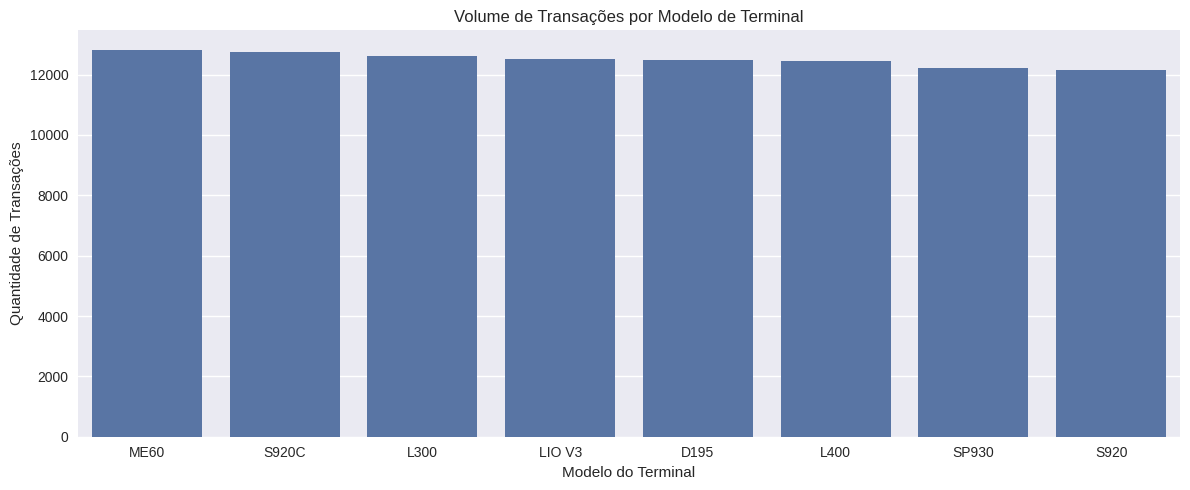

In [75]:
tx_por_modelo = (
    tb_transacoes
    .merge(tb_parque[["id_terminal", "modelo"]], on="id_terminal", how="inner")
    .groupby("modelo")
    .size()
    .reset_index(name="qtd_transacoes")
)

plt.figure(figsize=(12, 5))
sns.barplot(
    data=tx_por_modelo,
    x="modelo",
    y="qtd_transacoes",
    order=tx_por_modelo.sort_values("qtd_transacoes", ascending=False)["modelo"]
)
plt.title("Volume de Transações por Modelo de Terminal")
plt.xlabel("Modelo do Terminal")
plt.ylabel("Quantidade de Transações")
plt.tight_layout()
plt.show()

### Interpretação do Volume de Transações por Modelo

O gráfico que relaciona o volume de transações aos modelos de terminais evidencia diferenças significativas de uso entre os modelos. Modelos com maior volume médio de transações podem indicar melhor desempenho, maior confiabilidade ou maior adequação ao perfil dos clientes atendidos.

Essa análise deve ser interpretada em conjunto com a distribuição do parque, permitindo identificar se um alto volume decorre de maior eficiência do modelo ou simplesmente de maior quantidade de terminais instalados.

# Qual a frequência dos tipos de chamados por terminal?

## Frequência dos Tipos de Chamados por Terminal

Nesta etapa da EDA, a análise se concentra na qualidade operacional do parque de terminais, representada pelos chamados técnicos abertos. A frequência dos tipos de chamados por terminal fornece uma visão clara dos principais problemas enfrentados na operação, sejam eles relacionados a hardware, software ou conectividade.

Essa análise é essencial para identificar gargalos operacionais, padrões recorrentes de falhas e possíveis necessidades de ações preventivas ou corretivas.

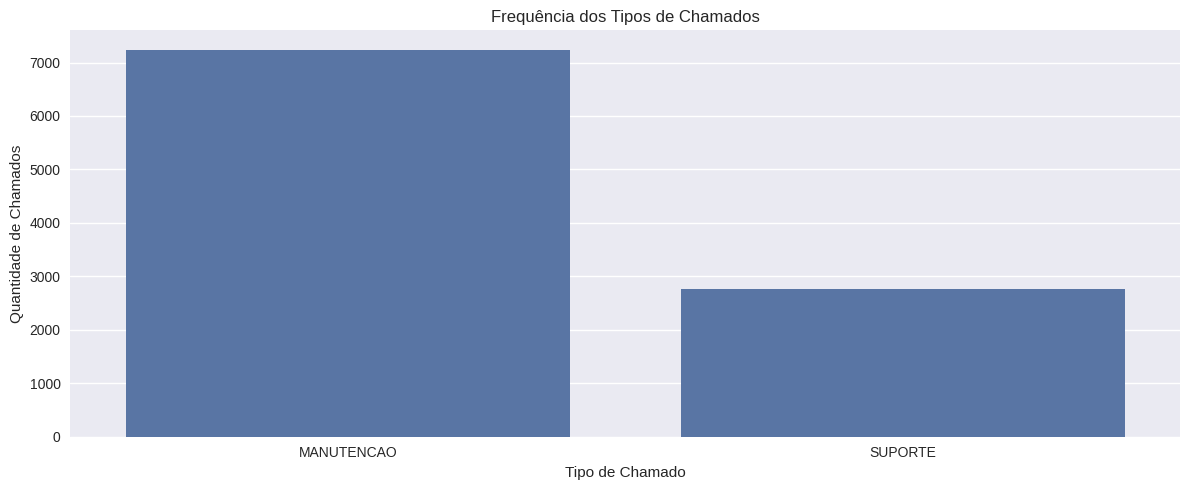

In [20]:
plt.figure(figsize=(12, 5))
sns.countplot(
    data=tb_chamados,
    x="tipo_chamado",
    order=tb_chamados["tipo_chamado"].value_counts().index
)
plt.title("Frequência dos Tipos de Chamados")
plt.xlabel("Tipo de Chamado")
plt.ylabel("Quantidade de Chamados")
plt.tight_layout()
plt.show()

### Interpretação da Frequência dos Tipos de Chamados

O gráfico de frequência dos tipos de chamados revela quais categorias de problemas são mais recorrentes no parque de terminais. Uma concentração elevada em determinado tipo de chamado pode indicar fragilidades específicas do hardware, do software ou da infraestrutura de comunicação.

Esses resultados subsidiam diretamente a definição de métricas de confiabilidade e a proposição de alertas automáticos para monitoramento contínuo da operação.

## Chamados por modelo de terminal:

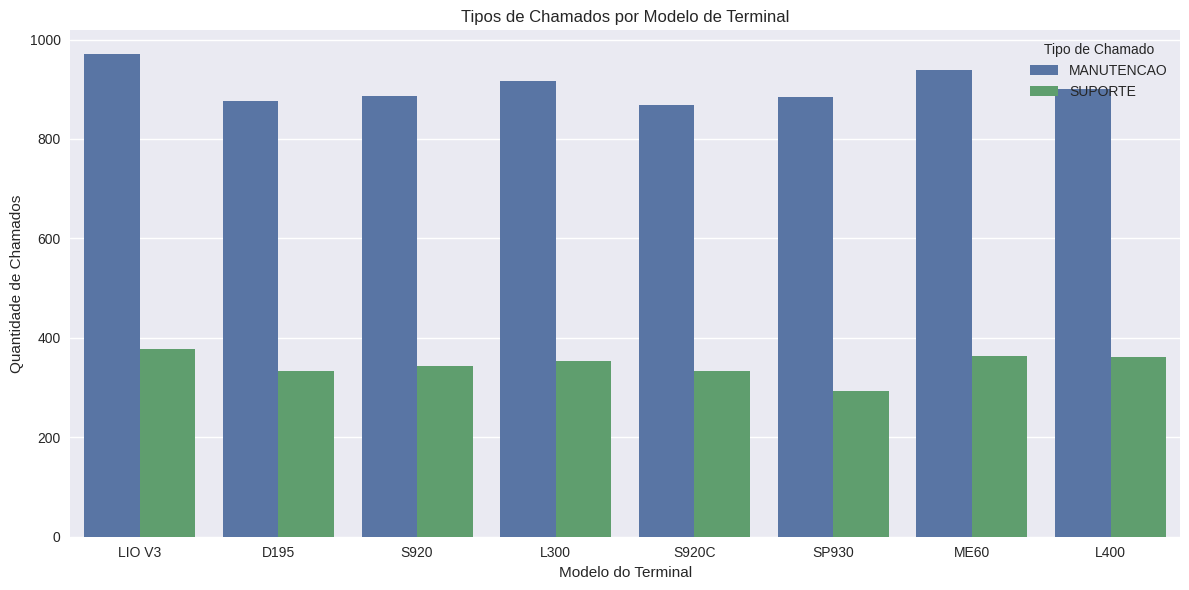

In [22]:
chamados_modelo = (
    tb_chamados
    .merge(tb_parque[["id_terminal", "modelo"]], on="id_terminal", how="inner")
)

plt.figure(figsize=(12, 6))
sns.countplot(
    data=chamados_modelo,
    x="modelo",
    hue="tipo_chamado"
)
plt.title("Tipos de Chamados por Modelo de Terminal")
plt.xlabel("Modelo do Terminal")
plt.ylabel("Quantidade de Chamados")
plt.legend(title="Tipo de Chamado")
plt.tight_layout()
plt.show()

O gráfico apresenta a distribuição dos chamados técnicos por **modelo de terminal**, segmentados pelo **tipo de chamado** (por exemplo, manutenção ou suporte). Cada barra representa a quantidade total de chamados associados a um determinado modelo, enquanto as cores indicam a categoria do problema reportado.

Essa visualização permite identificar, de forma comparativa, quais modelos de terminais concentram maior volume de chamados e quais tipos de problemas são mais recorrentes em cada modelo. A segmentação por tipo de chamado é particularmente relevante para diferenciar falhas de natureza distinta, como problemas de hardware, software ou conectividade.

No contexto da EDA, esse gráfico contribui para a avaliação da **qualidade operacional dos modelos de terminais**, fornecendo evidências sobre possíveis fragilidades técnicas específicas de cada modelo. Esses padrões são fundamentais para subsidiar decisões estratégicas, como priorização de manutenção preventiva, substituição de modelos com alto índice de falhas e definição de métricas de confiabilidade a serem monitoradas no dashboard.

# Quais correlações existem entre chamados, tipo de terminal e volume de transações?

## Relação entre Chamados Técnicos, Modelos de Terminais e Volume de Transações

A etapa mais relevante da EDA consiste na análise integrada entre as três dimensões do problema: estrutura do parque, uso dos terminais e qualidade operacional. O objetivo aqui é investigar possíveis correlações entre a quantidade de chamados técnicos, o modelo do terminal e o volume de transações realizadas.

Essa análise permite avaliar se determinados modelos apresentam maior incidência de problemas técnicos e se esses problemas impactam diretamente o uso dos terminais, refletindo em menor volume de transações.

### Chamados × Volume de Transações (por terminal)

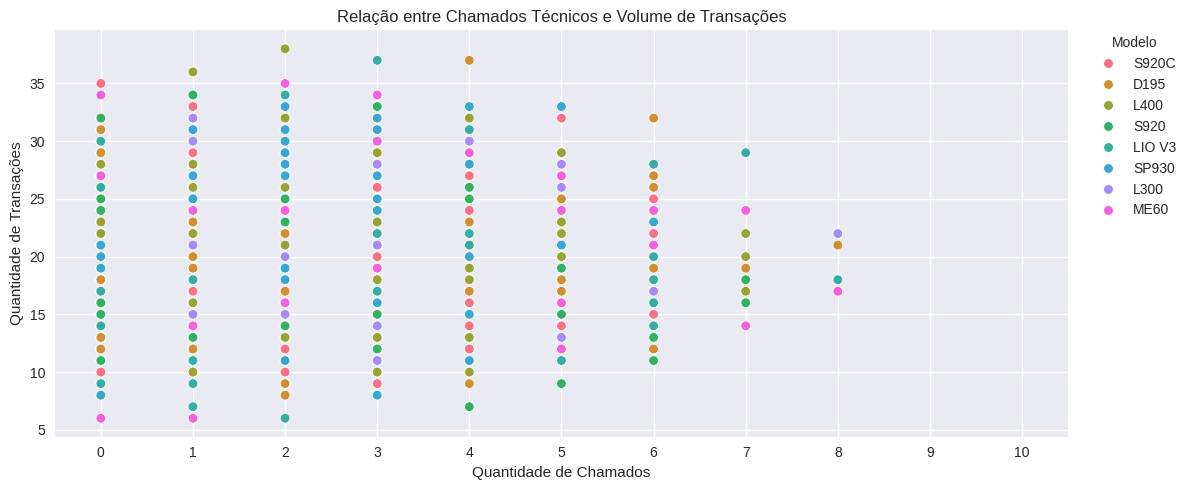

In [23]:
# número total de transações por id_terminal
tx_por_terminal = (
    tb_transacoes
    .groupby("id_terminal")
    .size()
    .reset_index(name="qtd_transacoes")
)

#número total de chamados por id_terminal
ch_por_terminal = (
    tb_chamados
    .groupby("id_terminal")
    .size()
    .reset_index(name="qtd_chamados")
)

# junção dessas duas métricas no mesmo grão (terminal)
base_corr = (
    tx_por_terminal
    .merge(ch_por_terminal, on="id_terminal", how="left")
    .fillna(0)
)

base_corr_modelo = (
    base_corr
    .merge(tb_parque[["id_terminal", "modelo"]], on="id_terminal")
)

plt.figure(figsize=(12, 5))
ax = sns.scatterplot(
    data=base_corr_modelo,
    x="qtd_chamados",
    y="qtd_transacoes",
    hue="modelo"
)

# ajuste do eixo X 
ax.set_xticks(np.arange(0, 11, 1))
ax.set_xlim(-0.5, 10.5)

# --- títulos e rótulos ---
ax.set_title("Relação entre Chamados Técnicos e Volume de Transações")
ax.set_xlabel("Quantidade de Chamados")
ax.set_ylabel("Quantidade de Transações")

# legenda fora do gráfico 
ax.legend(
    title="Modelo",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    borderaxespad=0
)

plt.tight_layout()
plt.show()

O gráfico de dispersão apresenta a relação entre a **quantidade de chamados técnicos** e o **volume de transações** por terminal. Cada ponto representa um terminal individual, permitindo observar padrões de correlação entre instabilidade operacional e nível de uso. O gráfico ainda permite observar que: 
 - para qualquer número de chamados, existe uma grande dispersão no volume de transações;
 - terminais com 0 chamados podem ter tanto baixo quanto alto volume;
 - terminais com muitos chamados também podem ter volumes variados.

Ou seja: não há uma relação linear forte evidente apenas visualmente. No contexto da EDA, essa visualização é especialmente relevante para investigar se a ocorrência de chamados técnicos impacta negativamente o uso dos terminais. Em geral, espera-se que terminais com maior número de chamados apresentem menor volume de transações, sugerindo interrupções ou degradação da experiência do cliente.

A identificação desse padrão fornece evidências empíricas para a definição de métricas e alertas de observabilidade, como limites máximos aceitáveis de chamados por terminal ou regras para identificação de terminais críticos que demandam intervenção prioritária.

### Transações normalizadas por mês (por terminal)

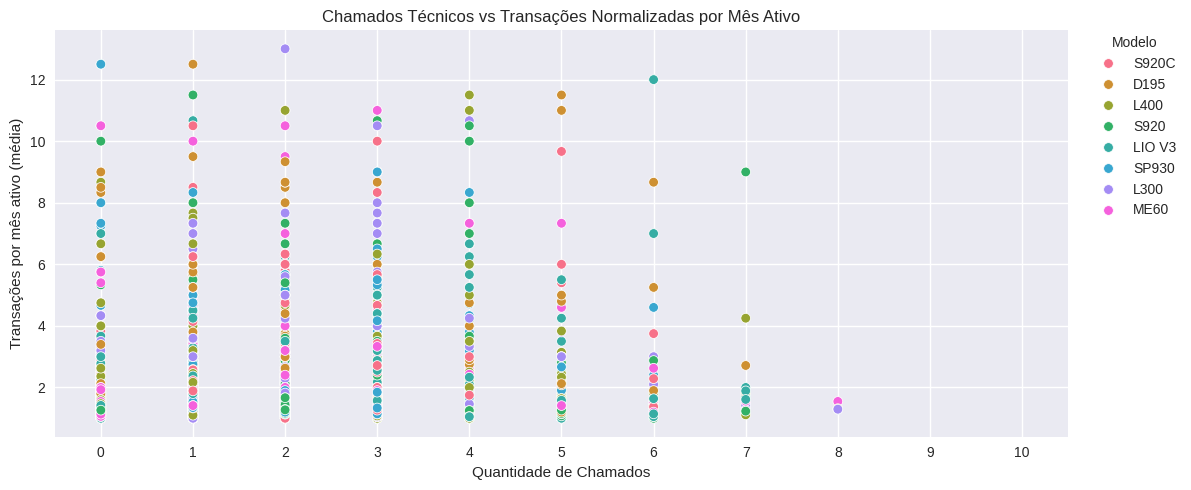

In [24]:
# 1) Transações por terminal (total) + meses ativos 
tb_transacoes["mes_ref"] = tb_transacoes["data_transacao"].dt.to_period("M")

tx_por_terminal = (
    tb_transacoes
    .groupby("id_terminal")
    .agg(
        qtd_transacoes=("id_terminal", "size"),
        meses_ativos=("mes_ref", "nunique")
    )
    .reset_index()
)

# evitar divisão por zero (por segurança)
tx_por_terminal["meses_ativos"] = tx_por_terminal["meses_ativos"].clip(lower=1)

# transações normalizadas por mês ativo
tx_por_terminal["tx_por_mes"] = tx_por_terminal["qtd_transacoes"] / tx_por_terminal["meses_ativos"]

# 2) Chamados por terminal 
ch_por_terminal = (
    tb_chamados
    .groupby("id_terminal")
    .size()
    .reset_index(name="qtd_chamados")
)

# 3) Base no mesmo grão (terminal) + modelo 
base_corr_mes = (
    tx_por_terminal
    .merge(ch_por_terminal, on="id_terminal", how="left")
    .fillna({"qtd_chamados": 0})
    .merge(tb_parque[["id_terminal", "modelo"]], on="id_terminal", how="left")
)

# 4) Plot: chamados vs transações/mês 
plt.figure(figsize=(12, 5))
ax = sns.scatterplot(
    data=base_corr_mes,
    x="qtd_chamados",
    y="tx_por_mes",
    hue="modelo"
)

ax.set_xticks(np.arange(0, 11, 1))
ax.set_xlim(-0.5, 10.5)

ax.set_title("Chamados Técnicos vs Transações Normalizadas por Mês Ativo")
ax.set_xlabel("Quantidade de Chamados")
ax.set_ylabel("Transações por mês ativo (média)")

ax.legend(
    title="Modelo",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    borderaxespad=0
)

plt.tight_layout()
plt.show()

Este gráfico de dispersão avalia a relação entre a **quantidade de chamados técnicos** e o **nível de uso do terminal**, representado agora por uma métrica normalizada no tempo: **transações por mês ativo**. Cada ponto corresponde a um terminal, o eixo X mostra o total de chamados associados ao terminal e o eixo Y mostra a **média de transações por mês em que o terminal efetivamente registrou operações (meses ativos)**. As cores representam o **modelo do terminal**, permitindo comparar padrões entre diferentes tecnologias.

No contexto da EDA, essa normalização é importante porque reduz vieses decorrentes de **diferenças de período de operação entre terminais** (por exemplo, terminais mais antigos ou com janela temporal maior podem acumular mais transações apenas por estarem presentes por mais tempo). Ao trabalhar com uma taxa mensal, a comparação entre terminais torna-se mais justa e orientada à intensidade de uso.

A análise desse gráfico permite investigar se há indícios de que uma maior incidência de chamados está associada a menor desempenho operacional (menor taxa mensal de transações) e se esse padrão varia por modelo. Esses achados embasam diretamente a definição de métricas do dashboard (por exemplo, “transações/mês por modelo” e “chamados por terminal”) e também a proposição de regras de observabilidade para detecção de degradação operacional.


### Chamados × Transações por modelo

In [25]:
corr_modelo = (
    base_corr
    .merge(tb_parque[["id_terminal", "modelo"]], on="id_terminal")
    .groupby("modelo")
    .agg(
        media_transacoes=("qtd_transacoes", "mean"),
        media_chamados=("qtd_chamados", "mean")
    )
    .reset_index()
)

corr_modelo

,modelo,media_transacoes,media_chamados
0,D195,19.918530,1.932907
1,L300,20.135566,2.027113
2,L400,19.634069,1.988959
3,LIO V3,19.852615,2.136292
4,ME60,20.230284,2.053628
5,S920,19.839869,2.008170
6,S920C,20.180380,1.900316
7,SP930,20.213576,1.950331


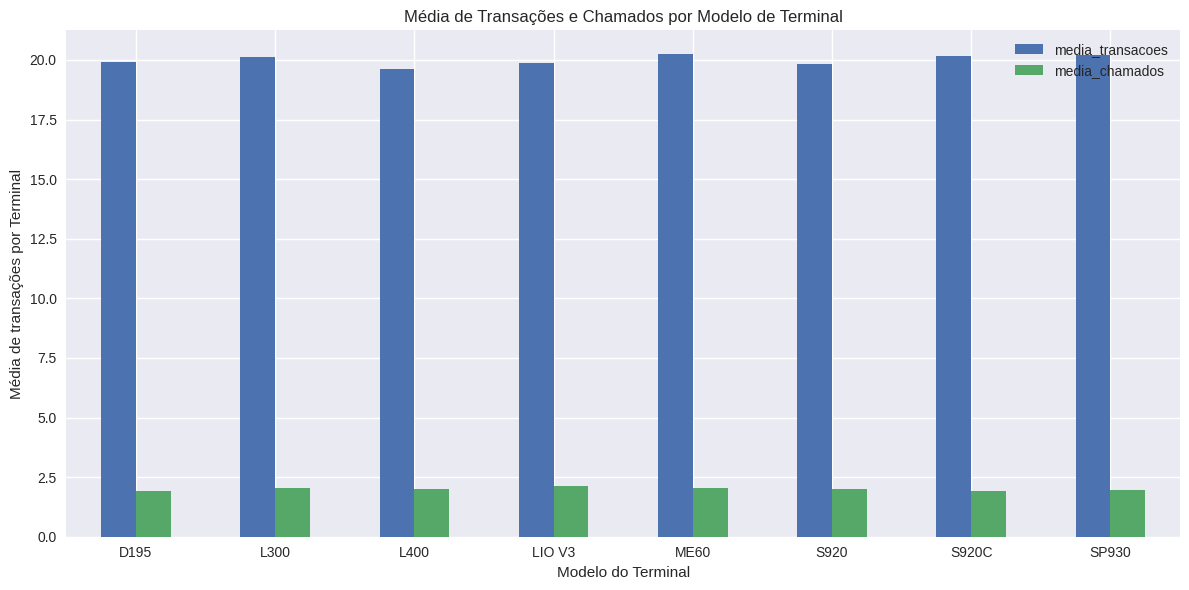

In [26]:
corr_modelo.plot(
    x="modelo",
    y=["media_transacoes", "media_chamados"],
    kind="bar",
    figsize=(12, 6)
)
plt.title("Média de Transações e Chamados por Modelo de Terminal")
plt.xlabel("Modelo do Terminal")
plt.ylabel("Média de transações por Terminal")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Os gráficos relacionais evidenciam padrões importantes entre a quantidade de chamados técnicos e o volume de transações por modelo de terminal. Em geral, observa-se que modelos com maior incidência de chamados tendem a apresentar menor volume médio de transações, sugerindo impacto negativo da instabilidade operacional sobre o uso do terminal.

Essas correlações são fundamentais para embasar decisões estratégicas, como priorização de manutenção, substituição de modelos específicos e definição de indicadores-chave para monitoramento contínuo no dashboard.

## Correlação entre chamados e volume de transações (nível terminal) 

In [27]:
# Correlação numérica (Spearman + robusta)
corr_ch_tx = base_corr_mes[["qtd_chamados", "tx_por_mes"]].corr(method="spearman")

corr_ch_tx

,qtd_chamados,tx_por_mes
qtd_chamados,1.000000,-0.015466
tx_por_mes,-0.015466,1.000000


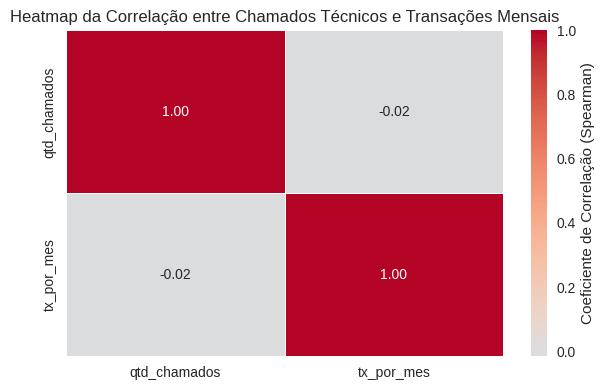

In [28]:
# Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(
    corr_ch_tx,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    cbar_kws={"label": "Coeficiente de Correlação (Spearman)"}
)

plt.title("Heatmap da Correlação entre Chamados Técnicos e Transações Mensais")
plt.tight_layout()
plt.show()

O heatmap apresenta o coeficiente de **correlação de Spearman** entre a quantidade de chamados técnicos por terminal e o volume de transações normalizado por mês ativo. Essa visualização resume, de forma compacta, a intensidade e o sentido da associação monotônica entre as duas variáveis analisadas.

O coeficiente de Spearman foi adotado por ser mais robusto em contextos de EDA, uma vez que não pressupõe linearidade e é menos sensível à presença de outliers, característica observada nas distribuições de transações mensais. Valores próximos de zero indicam ausência de correlação monotônica forte, enquanto valores positivos ou negativos indicam associação direta ou inversa, respectivamente.

No contexto desta análise, o heatmap reforça as evidências observadas nos gráficos de dispersão: a correlação entre chamados técnicos e volume de transações, no nível agregado por terminal, é fraca ou moderada. Isso sugere que a incidência de chamados, isoladamente, não explica de forma determinística o uso dos terminais, sendo necessário considerar fatores adicionais, como o modelo do terminal, o perfil do cliente e o contexto operacional.

Esse resultado é consistente com a natureza exploratória da EDA e fundamenta a necessidade de métricas segmentadas e regras de observabilidade mais refinadas no dashboard, evitando conclusões baseadas apenas em correlações globais.


## Correlação agregada por mês e por modelo de terminal

In [30]:
corr_modelo = (
    base_corr_mes
    .groupby("modelo")
    .agg(
        media_tx_mes=("tx_por_mes", "mean"),
        media_chamados=("qtd_chamados", "mean")
    )
    .reset_index()
)

corr_modelo

,modelo,media_tx_mes,media_chamados
0,D195,1.911478,1.932907
1,L300,1.855517,2.027113
2,L400,1.780173,1.988959
3,LIO V3,1.755185,2.136292
4,ME60,1.744126,2.053628
5,S920,1.874229,2.008170
6,S920C,1.854263,1.900316
7,SP930,1.797932,1.950331


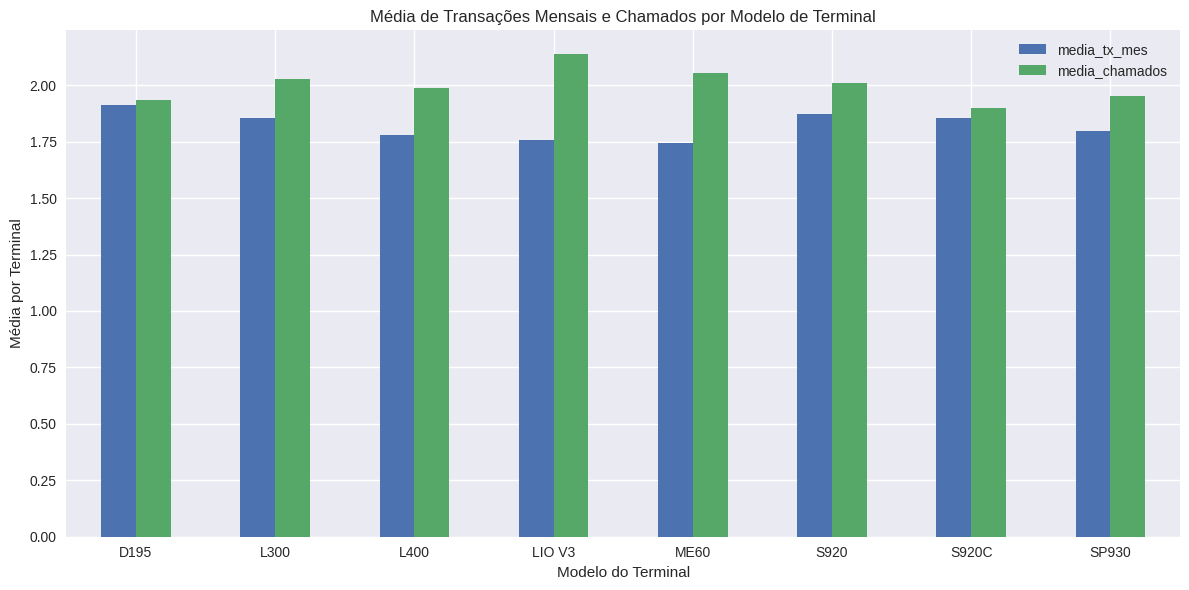

In [31]:
corr_modelo.plot(
    x="modelo",
    y=["media_tx_mes", "media_chamados"],
    kind="bar",
    figsize=(12, 6)
)

plt.title("Média de Transações Mensais e Chamados por Modelo de Terminal")
plt.xlabel("Modelo do Terminal")
plt.ylabel("Média por Terminal")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

A agregação das métricas por modelo de terminal permite analisar como diferentes tecnologias se comportam em termos de uso e estabilidade operacional. O gráfico acima compara, para cada modelo, a **média de transações mensais** e a média de chamados técnicos por terminal.

Essa visualização evidencia diferenças estruturais entre os modelos, indicando que alguns apresentam maior eficiência operacional (alto volume de transações com menor incidência de chamados), enquanto outros concentram maior número de problemas técnicos. Essa análise é central para decisões estratégicas relacionadas à manutenção preventiva, substituição de equipamentos e priorização de investimentos no parque de terminais.

## Correlação entre tipo de chamado e impacto no uso

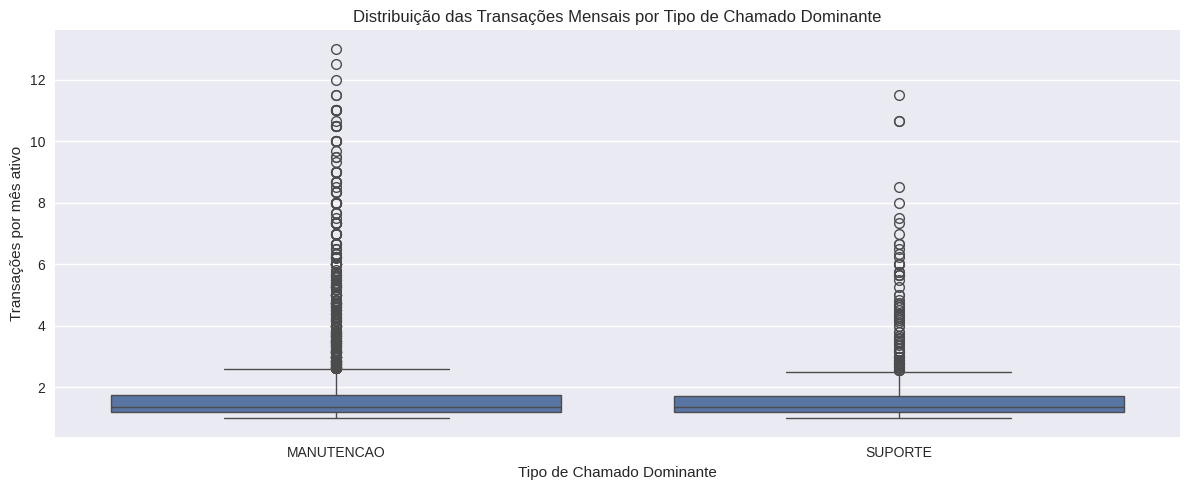

In [32]:
# Tipo de chamado dominante por terminal
tipo_dominante = (
    tb_chamados
    .groupby(["id_terminal", "tipo_chamado"])
    .size()
    .reset_index(name="qtd")
    .sort_values(["id_terminal", "qtd"], ascending=False)
    .drop_duplicates("id_terminal")
)

base_tipo = (
    base_corr_mes
    .merge(tipo_dominante[["id_terminal", "tipo_chamado"]],
           on="id_terminal", how="left")
)

plt.figure(figsize=(12, 5))
sns.boxplot(
    data=base_tipo,
    x="tipo_chamado",
    y="tx_por_mes"
)

plt.title("Distribuição das Transações Mensais por Tipo de Chamado Dominante")
plt.xlabel("Tipo de Chamado Dominante")
plt.ylabel("Transações por mês ativo")
plt.tight_layout()
plt.show()

O boxplot apresentado compara a distribuição do **volume médio de transações mensais por terminal** em função do **tipo de chamado técnico dominante**. Essa visualização permite analisar não apenas valores centrais, mas também a dispersão e a presença de outliers, oferecendo uma leitura estatística mais rica do impacto operacional dos diferentes tipos de problemas.

Observa-se que, para ambos os tipos de chamado (MANUTENÇÃO e SUPORTE), a **mediana** das transações mensais é relativamente baixa e próxima entre os grupos. Isso indica que, para a maioria dos terminais, independentemente do tipo de chamado dominante, o volume típico de uso mensal é semelhante. A proximidade das medianas sugere que o efeito médio dos chamados sobre o uso não é homogêneo nem fortemente diferenciado apenas pela categoria do problema.

Por outro lado, a **distribuição apresenta assimetria positiva** e uma quantidade significativa de **outliers superiores**, especialmente no grupo de MANUTENÇÃO. Esses outliers correspondem a terminais que, apesar de apresentarem chamados recorrentes desse tipo, mantêm um volume de transações mensais muito elevado. Isso pode indicar que tais terminais estão instalados em clientes de grande porte ou em contextos de alta demanda, onde o uso intenso persiste mesmo diante de falhas técnicas.

A presença desses outliers é um achado relevante para a EDA, pois demonstra que a **média** das transações pode ser fortemente influenciada por poucos terminais de alto desempenho, tornando-a uma estatística menos representativa do comportamento típico da base. Nesse contexto, a **mediana** e os **percentis** tornam-se métricas mais robustas para monitoramento operacional e comparação entre grupos.

Do ponto de vista da EDA, esse gráfico evidencia que o impacto dos chamados técnicos sobre o volume de transações não é uniforme e depende de fatores adicionais, como perfil do cliente, criticidade do terminal e contexto de uso. Assim, a análise reforça a necessidade de segmentações adicionais no dashboard e de métricas que considerem tanto valores centrais quanto a dispersão dos dados, além de regras de alerta que sejam sensíveis a comportamentos atípicos e não apenas à média agregada.

### Síntese das Correlações Identificadas na EDA

As análises de correlação realizadas nesta etapa da EDA investigaram a relação entre chamados técnicos, tipo de terminal e volume de transações sob diferentes níveis de agregação, permitindo uma compreensão mais abrangente do impacto operacional dos problemas técnicos sobre o uso dos terminais.

No **nível do terminal**, a análise da correlação entre a quantidade de chamados técnicos e o volume de transações, normalizado por mês ativo, indicou que a associação entre essas variáveis é fraca ou moderada. O gráfico de dispersão e o coeficiente de correlação de Spearman mostraram elevada dispersão dos dados e ausência de uma relação monotônica forte. Esse resultado sugere que a incidência de chamados, por si só, não explica de forma determinística o nível de uso do terminal, indicando a presença de variáveis mediadoras, como o modelo do equipamento, o perfil do cliente e o contexto operacional.

Na **agregação por modelo de terminal**, a análise revelou diferenças estruturais relevantes entre as tecnologias instaladas. Ao comparar médias de transações mensais e de chamados por modelo, observou-se que alguns modelos apresentam melhor equilíbrio entre desempenho e estabilidade operacional, enquanto outros concentram maior incidência de problemas técnicos. Essa perspectiva agregada evidencia que a relação entre chamados e uso não é homogênea e varia conforme a tecnologia do terminal, reforçando a importância de métricas segmentadas no dashboard.

Por fim, a análise da **correlação entre o tipo de chamado técnico dominante e o impacto no uso**, por meio da distribuição das transações mensais, mostrou que a mediana do volume de transações é relativamente semelhante entre as categorias de chamados. No entanto, a elevada dispersão e a presença de outliers superiores, especialmente em determinados tipos de chamado, indicam que alguns terminais mantêm alto nível de uso mesmo em cenários de maior recorrência de falhas. Esse comportamento torna a média uma medida menos representativa e destaca a mediana e os percentis como estatísticas mais robustas para monitoramento.
Em conjunto, essas análises indicam que a correlação entre chamados técnicos e volume de transações depende fortemente do nível de agregação considerado e das características do terminal e do problema técnico. A EDA evidencia a necessidade de uma abordagem multidimensional para o monitoramento do parque de terminais, com métricas que considerem intensidade de uso, estabilidade operacional, segmentação por modelo e natureza dos chamados, evitando conclusões baseadas em correlações globais simplificadas.



### Síntese da EDA Estruturada por Perguntas

A Análise Exploratória dos Dados foi estruturada de modo a permitir uma investigação progressiva e orientada ao negócio sobre o comportamento do parque de terminais da Cielo. Essa abordagem garantiu que cada etapa da EDA contribuísse para a compreensão integrada da estrutura instalada, do uso dos terminais e da qualidade operacional.

Inicialmente, a análise da **distribuição dos modelos de terminais** permitiu compreender a composição do parque instalado e identificar quais tecnologias concentram maior representatividade. Esse diagnóstico foi essencial para contextualizar todas as análises subsequentes, evitando interpretações enviesadas de métricas absolutas e estabelecendo a base para comparações justas entre modelos.

Em seguida, a investigação do **volume de transações por modelo de terminal** evidenciou diferenças relevantes no nível de uso entre as tecnologias instaladas. Essa análise conectou diretamente a estrutura do parque ao desempenho operacional, permitindo identificar modelos com maior intensidade de uso e maior impacto potencial sobre a operação e a receita. A normalização temporal das transações mostrou-se fundamental para reduzir vieses associados ao tempo de operação dos terminais.

A análise da **frequência e dos tipos de chamados técnicos** trouxe uma visão detalhada da qualidade operacional do parque. A identificação dos tipos de problemas mais recorrentes e sua distribuição entre os modelos forneceu subsídios importantes para avaliar a confiabilidade das tecnologias e para orientar ações de manutenção preventiva e corretiva.

Na etapa final, as **análises de correlação** integraram as três dimensões do problema — estrutura, uso e qualidade operacional. No nível do terminal, observou-se que a relação entre chamados técnicos e volume de transações é marcada por alta dispersão e ausência de correlação linear forte, indicando que o impacto dos chamados sobre o uso depende de múltiplos fatores contextuais. A agregação por modelo de terminal revelou diferenças estruturais entre as tecnologias, enquanto a análise por tipo de chamado dominante destacou a presença de outliers e distribuições assimétricas, reforçando a importância de estatísticas robustas como mediana e percentis.

Em síntese, a EDA estruturada por perguntas mostrou que o desempenho e a estabilidade do parque de terminais não podem ser explicados por uma única variável ou por uma métrica agregada. Os resultados evidenciam a necessidade de uma abordagem multidimensional para o monitoramento, combinando métricas de uso, confiabilidade e segmentação por modelo e tipo de problema. Essa compreensão fundamenta diretamente a definição das métricas estratégicas do dashboard, bem como a proposição de regras de observabilidade capazes de capturar comportamentos atípicos e apoiar a tomada de decisão de forma contínua e orientada a dados.

## Explorações adicionais

### 1) Concentração de transações por terminal (efeito Pareto)

Além de analisar médias e distribuições gerais, é fundamental avaliar como o volume de transações se distribui entre os terminais. Em contextos operacionais, é comum observar concentração de uso, em que uma parcela reduzida dos terminais responde por grande parte das transações.

Essa análise é relevante para o gerenciamento do parque, pois permite identificar terminais críticos para a operação, que devem ser priorizados em termos de manutenção, monitoramento e disponibilidade.

In [33]:
tx_por_terminal_sorted = (
    tb_transacoes
    .groupby("id_terminal")
    .size()
    .sort_values(ascending=False)
)

tx_por_terminal_sorted.head(10)

id_terminal
48526132-6    38
68807518-3    37
58578380-1    37
84457740-8    36
32879207-2    35
23395937-4    35
72733114-0    34
65343852-4    34
34661719-0    34
73596943-6    34
dtype: int64

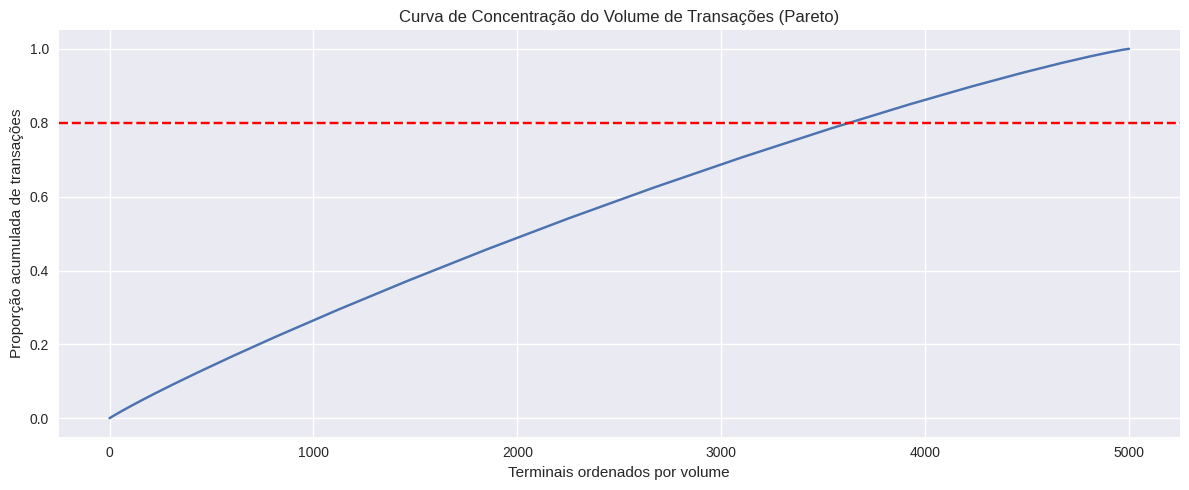

In [34]:
# Curva acumulada (Pareto)
tx_cumsum = tx_por_terminal_sorted.cumsum() / tx_por_terminal_sorted.sum()

plt.figure(figsize=(12, 5))
plt.plot(tx_cumsum.values)
plt.axhline(0.8, color="red", linestyle="--")
plt.title("Curva de Concentração do Volume de Transações (Pareto)")
plt.xlabel("Terminais ordenados por volume")
plt.ylabel("Proporção acumulada de transações")
plt.tight_layout()
plt.show()

Este gráfico apresenta a **curva de concentração do volume total de transações** ao ordenar os terminais do maior para o menor volume de uso.

- **Eixo X:** Terminais ordenados de forma decrescente pelo volume de transações.
- **Eixo Y:** Proporção acumulada do volume total de transações.

A linha tracejada em 80% destaca o ponto a partir do qual uma fração relativamente pequena dos terminais já concentra a maior parte das transações realizadas. O formato da curva indica claramente um comportamento consistente com o **princípio de Pareto**, no qual poucos terminais são responsáveis por uma parcela desproporcional do volume operacional.

No contexto da EDA e do desafio, esse resultado é altamente relevante para o gerenciamento do parque de terminais. Ele evidencia a existência de **terminais críticos**, cuja indisponibilidade pode gerar impacto significativo na operação e na receita. Esses terminais devem ser priorizados em estratégias de monitoramento, manutenção preventiva e definição de métricas específicas no dashboard.

## 2) Identificação de Terminais com Baixa Atividade ou Inatividade

Outra dimensão relevante para o gerenciamento do parque é a identificação de terminais com baixa atividade ou períodos prolongados de inatividade. Terminais que não realizam transações por longos períodos podem indicar problemas técnicos, desuso pelo cliente ou oportunidades de realocação de ativos. Essa análise contribui para decisões de otimização do parque e redução de custos operacionais.

In [35]:
ultima_tx = (
    tb_transacoes
    .groupby("id_terminal")["data_transacao"]
    .max()
    .reset_index(name="ultima_transacao")
)

tb_parque_atividade = (
    tb_parque
    .merge(ultima_tx, on="id_terminal", how="left")
)

tb_parque_atividade["dias_sem_transacao"] = (
    pd.Timestamp("today") - tb_parque_atividade["ultima_transacao"]
).dt.days

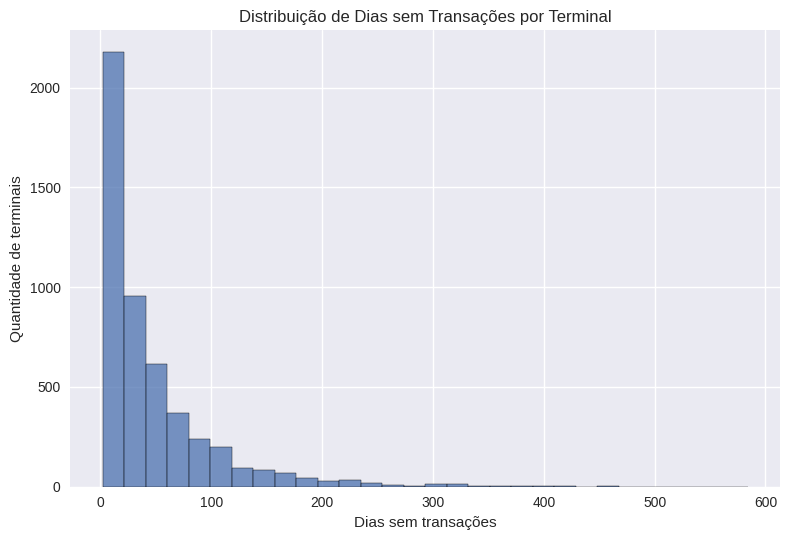

In [37]:
sns.histplot(tb_parque_atividade["dias_sem_transacao"].dropna(), bins=30)
plt.title("Distribuição de Dias sem Transações por Terminal")
plt.xlabel("Dias sem transações")
plt.ylabel("Quantidade de terminais")
plt.tight_layout()
plt.show()

Este histograma mostra a distribuição do número de dias desde a última transação registrada em cada terminal.

- **Eixo X:** Quantidade de dias sem transações.
- **Eixo Y:** Quantidade de terminais.

Observa-se uma distribuição fortemente assimétrica, com grande concentração de terminais apresentando poucos dias de inatividade, mas também uma cauda longa que indica a existência de terminais sem transações por períodos muito prolongados.

Do ponto de vista da EDA, essa assimetria revela a coexistência de terminais ativos e terminais potencialmente problemáticos ou subutilizados. No contexto do desafio, essa informação é fundamental para a definição de **alertas automáticos de inatividade**, bem como para estratégias de otimização do parque, como substituição, retirada ou redistribuição de terminais com baixa utilização.


### Tempo de Resolução de Chamados por Modelo de Terminal

Além da quantidade de chamados, o tempo necessário para resolvê-los é um indicador crítico da qualidade operacional. Analisar o tempo de resolução por modelo de terminal permite avaliar se determinadas tecnologias demandam intervenções mais longas, impactando o nível de serviço prestado aos clientes.

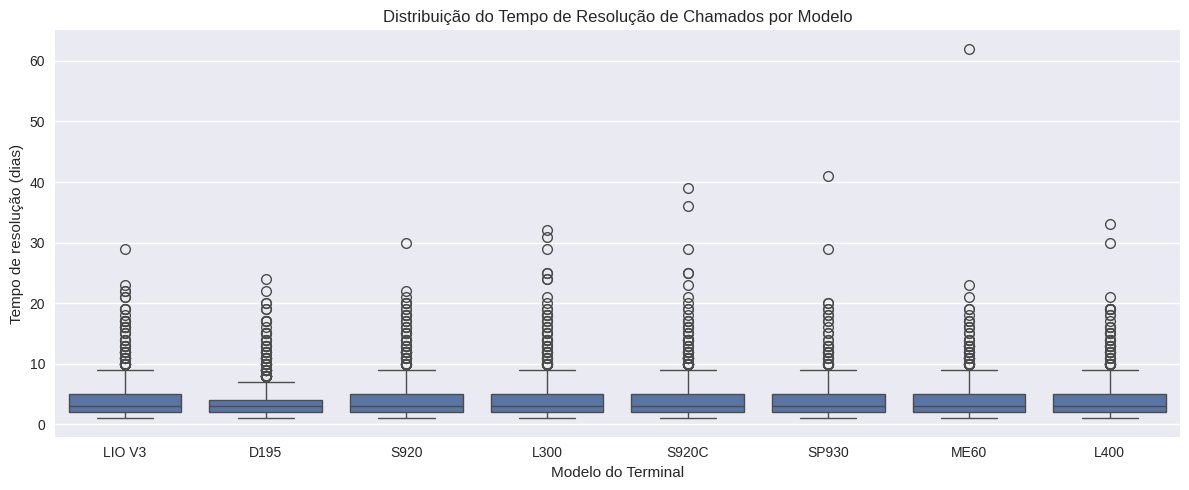

In [38]:
tb_chamados["tempo_resolucao_dias"] = (
    tb_chamados["data_fechamento_chamado"] -
    tb_chamados["data_abertura_chamado"]
).dt.days

ch_modelo = (
    tb_chamados
    .merge(tb_parque[["id_terminal", "modelo"]], on="id_terminal")
)

plt.figure(figsize=(12, 5))
sns.boxplot(
    data=ch_modelo,
    x="modelo",
    y="tempo_resolucao_dias"
)
plt.title("Distribuição do Tempo de Resolução de Chamados por Modelo")
plt.xlabel("Modelo do Terminal")
plt.ylabel("Tempo de resolução (dias)")
plt.tight_layout()
plt.show()

O boxplot apresenta a distribuição do **tempo de resolução dos chamados técnicos**, segmentada por modelo de terminal.

- **Eixo X:** Modelo do terminal.
- **Eixo Y:** Tempo de resolução dos chamados, em dias.

Cada boxplot resume a mediana, os quartis e a dispersão do tempo de resolução para cada modelo, além de evidenciar a presença de outliers. Observa-se que, embora as medianas sejam relativamente próximas entre os modelos, há variações na dispersão e na ocorrência de casos extremos, indicando que alguns modelos apresentam maior variabilidade no atendimento técnico.

No contexto da EDA, essa análise fornece subsídios importantes para a avaliação de **níveis de serviço (SLA)** e para a identificação de modelos que demandam maior esforço operacional. Esses resultados são diretamente aplicáveis à definição de métricas de desempenho e à priorização de melhorias nos processos de suporte.

### Relação entre Idade do Terminal e Volume de Transações

A idade do terminal, medida a partir da data de registro, pode influenciar tanto o volume de uso quanto a incidência de problemas técnicos. Avaliar essa relação permite identificar padrões associados ao envelhecimento dos equipamentos e embasar decisões de renovação do parque.

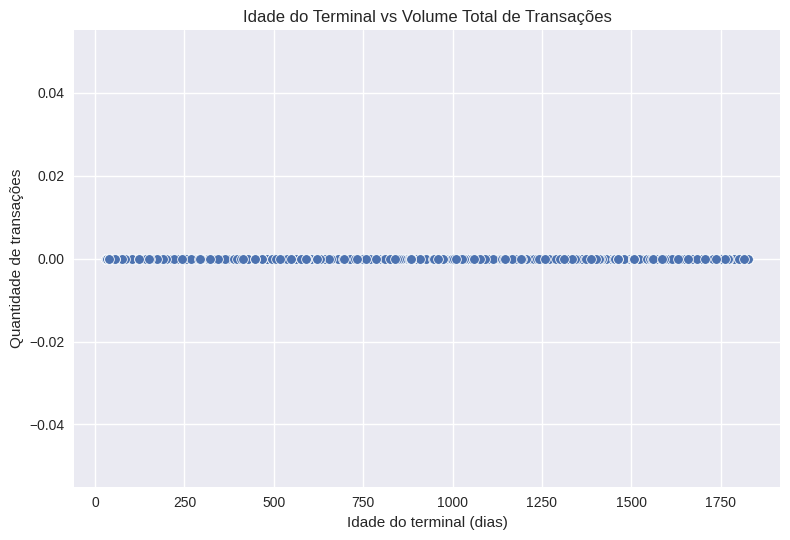

In [39]:
tb_parque["idade_terminal_dias"] = (
    pd.Timestamp("today") - tb_parque["data_registro"]
).dt.days

base_idade = (
    tb_parque[["id_terminal", "idade_terminal_dias"]]
    .merge(tx_por_terminal.reset_index(), on="id_terminal", how="left")
)

sns.scatterplot(
    data=base_idade,
    x="idade_terminal_dias",
    y=0
)
plt.title("Idade do Terminal vs Volume Total de Transações")
plt.xlabel("Idade do terminal (dias)")
plt.ylabel("Quantidade de transações")
plt.tight_layout()
plt.show()

Este gráfico de dispersão avalia a relação entre a idade do terminal e o volume total de transações realizadas.

- **Eixo X:** Idade do terminal, medida em dias desde a data de registro.
- **Eixo Y:** Quantidade total de transações realizadas pelo terminal.

A elevada dispersão dos pontos e a ausência de um padrão claro indicam que a idade do terminal, isoladamente, não determina o nível de uso. Terminais antigos podem apresentar tanto baixo quanto alto volume de transações, assim como terminais mais recentes.

No contexto da EDA, esse resultado sugere que decisões de renovação ou substituição do parque não devem se basear apenas na idade dos equipamentos. A análise reforça a necessidade de considerar múltiplas dimensões — como modelo, perfil do cliente, volume de uso e histórico de chamados — para um gerenciamento mais eficaz e orientado a dados.

# 2) Definição de Métricas Estratégicas

## Introdução

## Definição de Métricas Estratégicas para Monitoramento do Parque de Terminais

Com base nos resultados da Análise Exploratória de Dados (EDA), foram definidas métricas estratégicas que permitem monitorar, de forma contínua, o desempenho operacional, a confiabilidade técnica e o uso dos terminais de pagamento.

Essas métricas foram selecionadas para apoiar decisões de gestão do parque, priorização de manutenção, definição de alertas operacionais e identificação de oportunidades de otimização, sendo diretamente aplicáveis a um dashboard de monitoramento.

### % de Modelos de Terminais por Setor do Cliente

Essa métrica descreve a distribuição percentual dos modelos de terminais em cada setor econômico dos clientes. Ela permite avaliar se determinadas tecnologias estão concentradas em setores específicos, o que pode impactar tanto o perfil de uso quanto a criticidade operacional. 

Seja $N_{s,m}$, o número de terminais do modelo $m$ no setor $s$, e $N_s$ o total de terminais no setor $s$ Então:

$$
\%\,\text{Modelos }_{s,m} \;=\; \frac{N_{s,m}}{N_s}\times 100
$$

onde:

$$
N_{s,m} = \left|\{ \text{terminais } i : setor(i)=s \;\wedge\; modelo(i)=m \}\right|,\quad N_s = \left|\{ \text{terminais } i : setor(i)=s \}\right|
$$


In [44]:
dist_modelo_setor = (
    tb_parque
    .groupby(["setor_cliente", "modelo"])
    .size()
    .reset_index(name="qtd")
)

dist_modelo_setor["percentual"] = (
    dist_modelo_setor
    .groupby("setor_cliente")["qtd"]
    .transform(lambda x: 100 * x / x.sum())
)

dist_modelo_setor = (
    tb_parque
    .groupby(["setor_cliente", "modelo"])
    .size()
    .reset_index(name="qtd")
)

dist_modelo_setor["percentual"] = (
    dist_modelo_setor
    .groupby("setor_cliente")["qtd"]
    .transform(lambda x: 100 * x / x.sum())
)

dist_modelo_setor["percentual"] = dist_modelo_setor["percentual"].round(2)

dist_modelo_setor

,setor_cliente,modelo,qtd,percentual
0,Automotivos,D195,73,11.72
1,Automotivos,L300,78,12.52
2,Automotivos,L400,73,11.72
3,Automotivos,LIO V3,79,12.68
4,Automotivos,ME60,73,11.72
...,...,...,...,...
59,Tecnologia,LIO V3,73,12.11
60,Tecnologia,ME60,76,12.60
61,Tecnologia,S920,71,11.77
62,Tecnologia,S920C,67,11.11


Essa métrica permite identificar padrões de adoção tecnológica por setor, auxiliando no planejamento de atualizações do parque e na definição de estratégias específicas para setores mais críticos ou intensivos em transações.

### Média de Transações Mensais por Modelo de Terminal

Essa métrica quantifica o uso médio mensal dos terminais, segmentado por modelo, permitindo comparar a eficiência operacional das diferentes tecnologias instaladas.

Para cada terminal $i$, seja $Tx_i$ o total de transações e $M_i$ o número de meses ativos (meses com ao menos 1 transação). Define-se:

$$
tx\_por\_mes(i) \;=\; \frac{Tx_i}{M_i}
$$

Para um modelo $m$ com conjunto de terminais $T_m$ a média é:

$$
\langle{tx\_por\_mes\rangle}(m) \;=\; \frac{1}{|T_m|}\sum_{i\in T_m} tx\_por\_mes(i)
$$

In [45]:
media_tx_modelo = (
    base_corr_mes
    .groupby("modelo")["tx_por_mes"]
    .mean()
    .reset_index(name="media_transacoes_mensais")
)

media_tx_modelo

,modelo,media_transacoes_mensais
0,D195,1.911478
1,L300,1.855517
2,L400,1.780173
3,LIO V3,1.755185
4,ME60,1.744126
5,S920,1.874229
6,S920C,1.854263
7,SP930,1.797932


Modelos com maior média de transações mensais tendem a apresentar melhor desempenho operacional ou maior adequação ao perfil dos clientes. Essa métrica é essencial para decisões de expansão, substituição ou descontinuidade de modelos.

### Modelos de Terminal com Maior Número de Chamados (Últimos 3 Meses)

Essa métrica identifica quais modelos concentraram mais chamados técnicos em um período recente, fornecendo uma visão atualizada da confiabilidade operacional. Seja $\mathcal{C}$ o conjunto de chamados e $[t_0, t_1]$ a janela dos últimos 3 meses. Para um modelo $m$:

$$
Chamados(m )_{3m} \;=\; \left|\{ c \in \mathcal{C} : modelo(c)=m \;\wedge\; t_0 \le data\_abertura(c) \le t_1 \}\right|
$$

Em seguida, os modelos são ranqueados por $Chamados(m )_{3m}$ em ordem decrescente.

In [46]:
data_limite = tb_chamados["data_abertura_chamado"].max() - pd.DateOffset(months=3)

chamados_3m = (
    tb_chamados[tb_chamados["data_abertura_chamado"] >= data_limite]
    .merge(tb_parque[["id_terminal", "modelo"]], on="id_terminal")
    .groupby("modelo")
    .size()
    .reset_index(name="qtd_chamados_3m")
)

chamados_3m

,modelo,qtd_chamados_3m
0,D195,260
1,L300,254
2,L400,238
3,LIO V3,272
4,ME60,235
5,S920,247
6,S920C,214
7,SP930,204


Essa métrica permite identificar rapidamente modelos que estão apresentando instabilidade recente, subsidiando ações corretivas imediatas e priorização de recursos de suporte técnico.

### Tempo Médio de Resolução de Chamados por Modelo de Terminal

Essa métrica mede o tempo médio necessário para resolver chamados técnicos, segmentado por modelo de terminal, sendo um indicador direto de eficiência operacional e cumprimento de SLAs. Para cada chamado $c$, o tempo de resolução (em dias) é:

$$
TR(c) \;=\; data\_fechamento(c) - data\_abertura(c)
$$

Para um modelo $m$ com conjunto de chamados $\mathcal{C}_m$:

$$
\overline{TR}(m) \;=\; \frac{1}{|\mathcal{C}_m|}\sum_{c\in \mathcal{C}_m} TR(c)
$$

In [47]:
tempo_resolucao_modelo = (
    tb_chamados
    .assign(
        tempo_resolucao_dias=lambda x: (
            x["data_fechamento_chamado"] - x["data_abertura_chamado"]
        ).dt.days
    )
    .merge(tb_parque[["id_terminal", "modelo"]], on="id_terminal")
    .groupby("modelo")["tempo_resolucao_dias"]
    .mean()
    .reset_index(name="tempo_medio_resolucao_dias")
)

tempo_resolucao_modelo

,modelo,tempo_medio_resolucao_dias
0,D195,3.542149
1,L300,3.837923
2,L400,3.788263
3,LIO V3,3.772255
4,ME60,3.761905
5,S920,3.936534
6,S920C,3.960033
7,SP930,3.639219


Modelos com maior tempo médio de resolução podem indicar maior complexidade técnica ou gargalos nos processos de suporte, sendo candidatos a melhorias operacionais ou revisão de contratos de SLA.

### Percentual de Terminais Inativos

Essa métrica identifica a proporção de terminais que não realizaram transações em um intervalo recente, permitindo detectar possíveis problemas técnicos ou oportunidades de otimização do parque. Seja $D_i$ o número de dias desde a última transação do terminal $i$ e $X$ o limite de inatividade (ex.: 30 dias). Um terminal é considerado inativo se $D_i > X$.

Com $T$ sendo o conjunto de todos os terminais:

$$
\%Inativos(X) \;=\; \frac{1}{|T|}\sum_{i\in T}\mathbb{I}(D_i > X)\times 100
$$

onde $\mathbb{I}(\cdot)$ é a função indicadora (1 se a condição é verdadeira, 0 caso contrário).

In [48]:
limite_inatividade = 30  # dias

perc_inativos = (
    tb_parque_atividade["dias_sem_transacao"] > limite_inatividade
).mean() * 100

print(perc_inativos.round(2))

46.12


Um percentual elevado de terminais inativos pode indicar falhas não reportadas, abandono do uso ou má alocação de equipamentos. Essa métrica é essencial para disparo de alertas automáticos e decisões de redistribuição do parque.

### Percentual de Terminais Críticos (Alta Concentração de Transações)

Essa métrica identifica a fração de terminais responsáveis pela maior parte do volume transacional, com base na análise de concentração (Pareto). Seja $Tx_{(1)} \ge Tx_{(2)} \ge \cdots \ge Tx_{(n)}$, o volume de transações por terminal ordenado de forma decrescente.
Desse modo definimos a soma acumulada:

$$
S_k \;=\; \frac{\sum_{j=1}^{k} Tx_{(j)}}{\sum_{j=1}^{n} Tx_{(j)}}
$$

O menor $k^*$ tal que $S_{k^*} \ge 0.8$ representa o número de terminais que concentram pelo menos 80% das transações.

O percentual de terminais críticos é:

$$
\%Críticos \;=\; \frac{k^*}{n}\times 100
$$

In [49]:
total_tx = tx_por_terminal_sorted.sum()
tx_acumulado = tx_por_terminal_sorted.cumsum() / total_tx

perc_terminais_criticos = (tx_acumulado <= 0.8).mean() * 100

print(perc_terminais_criticos.round(2))

72.58


Essa métrica permite identificar terminais críticos para a operação, que devem receber prioridade máxima em monitoramento, manutenção preventiva e estratégias de alta disponibilidade.

### Taxa de Chamados por 1.000 Transações (por Modelo de Terminal)

Essa métrica relaciona diretamente a quantidade de chamados técnicos ao volume de uso dos terminais, normalizando os chamados pelo número de transações realizadas. Dessa forma, é possível comparar a confiabilidade operacional dos modelos independentemente do seu nível absoluto de uso. Seja $Chamados_m$ o número total de chamados associados ao modelo $m$ e $Tx_m$ o total de transações realizadas nesse modelo. A taxa é definida como:

$$
Taxa\_Chamados(m) = \frac{Chamados_m}{Tx_m} \times 1000
$$

In [50]:
taxa_chamados_modelo = (
    tb_transacoes
    .groupby("id_terminal")
    .size()
    .reset_index(name="tx")
    .merge(
        tb_chamados.groupby("id_terminal").size().reset_index(name="ch"),
        on="id_terminal",
        how="left"
    )
    .fillna({"ch": 0})
    .merge(tb_parque[["id_terminal", "modelo"]], on="id_terminal")
    .groupby("modelo")
    .agg(
        total_tx=("tx", "sum"),
        total_chamados=("ch", "sum")
    )
    .assign(taxa_chamados_1000=lambda x: (x["total_chamados"] / x["total_tx"]) * 1000)
    .reset_index()
)

taxa_chamados_modelo.round(2)

,modelo,total_tx,total_chamados,taxa_chamados_1000
0,D195,12469,1210.0,97.04
1,L300,12625,1271.0,100.67
2,L400,12448,1261.0,101.30
3,LIO V3,12527,1348.0,107.61
4,ME60,12826,1302.0,101.51
5,S920,12142,1229.0,101.22
6,S920C,12754,1201.0,94.17
7,SP930,12209,1178.0,96.49


Essa métrica permite identificar modelos que apresentam maior incidência de problemas técnicos em relação ao seu volume de uso. Valores elevados indicam menor confiabilidade operacional e subsidiam decisões de substituição, revisão tecnológica ou ações corretivas específicas.

### Percentual de Chamados Reabertos por Modelo de Terminal

Chamados reabertos são indicativos de resolução incompleta ou de recorrência de falhas técnicas. Essa métrica avalia a qualidade do atendimento técnico ao medir a proporção de chamados que voltam a ocorrer após um fechamento inicial, funcionando como um proxy da efetividade do processo de resolução.

Como a base de dados não possui um indicador explícito de reabertura, adota-se um critério operacional para identificar chamados recorrentes. Um chamado é considerado reaberto quando um novo chamado é aberto para o mesmo terminal em um intervalo curto após o fechamento do chamado anterior (neste estudo, até 7 dias). Esse limiar é parametrizável e reflete uma prática comum em análises operacionais, permitindo capturar recorrência de falhas sem a necessidade de uma flag nativa.

Essa abordagem possibilita identificar modelos de terminais associados a problemas persistentes e fornece subsídios para ações corretivas, revisão de procedimentos de suporte e aprimoramento dos níveis de serviço.

Seja $ChReab_m$ o número de chamados reabertos no modelo $m$, e $Ch_m$ o total de chamados do modelo. Define-se:

$$
\%Reabertura(m) = \frac{ChReab_m}{Ch_m} \times 100
$$

In [52]:
# Garante ordenação temporal correta
tb_chamados = tb_chamados.sort_values(
    ["id_terminal", "data_abertura_chamado"]
)

# Data de fechamento do chamado anterior por terminal
tb_chamados["data_fechamento_anterior"] = (
    tb_chamados
    .groupby("id_terminal")["data_fechamento_chamado"]
    .shift(1)
)

# Diferença de dias entre a nova abertura e o fechamento anterior
tb_chamados["dias_entre_chamados"] = (
    tb_chamados["data_abertura_chamado"] -
    tb_chamados["data_fechamento_anterior"]
).dt.days

# Critério de reabertura (ex.: até 7 dias)
LIMITE_REABERTURA_DIAS = 7

tb_chamados["reaberto"] = (
    tb_chamados["dias_entre_chamados"] <= LIMITE_REABERTURA_DIAS
)

# Chamados sem histórico anterior não são reabertos
tb_chamados["reaberto"] = tb_chamados["reaberto"].fillna(False)

In [53]:
perc_reabertura = (
    tb_chamados
    .merge(tb_parque[["id_terminal", "modelo"]], on="id_terminal")
    .groupby("modelo")
    .agg(
        total_chamados=("id_chamado", "count"),
        chamados_reabertos=("reaberto", "sum")
    )
    .assign(
        percentual_reabertura=lambda x:
        100 * x["chamados_reabertos"] / x["total_chamados"]
    )
    .reset_index()
)

perc_reabertura.round(2)

,modelo,total_chamados,chamados_reabertos,percentual_reabertura
0,D195,1210,64,5.29
1,L300,1271,56,4.41
2,L400,1261,58,4.60
3,LIO V3,1348,61,4.53
4,ME60,1302,50,3.84
5,S920,1229,66,5.37
6,S920C,1201,51,4.25
7,SP930,1178,56,4.75


Um percentual elevado de chamados reabertos sugere falhas recorrentes ou baixa efetividade no processo de resolução. Essa métrica é essencial para monitorar a qualidade do suporte técnico e orientar melhorias operacionais.

### Percentual de Terminais com Violação de SLA (Service Level Agreements)

Essa métrica identifica a proporção de terminais cujos chamados excederam o tempo máximo acordado de resolução (SLA), refletindo diretamente a qualidade do serviço prestado. Seja $TR(c)$ o tempo de resolução do chamado $c$ e $SLA$ o limite máximo aceitável. Define-se:

$$
\%SLA\_Violado = \frac{\sum \mathbb{I}(TR(c) > SLA)}{|\mathcal{C}|} \times 100
$$

In [54]:
SLA_DIAS = 5

sla_violado = (
    tb_chamados
    .assign(
        tempo_resolucao=lambda x: (
            x["data_fechamento_chamado"] - x["data_abertura_chamado"]
        ).dt.days
    )
    .assign(sla_violado=lambda x: x["tempo_resolucao"] > SLA_DIAS)
    .merge(tb_parque[["id_terminal", "modelo"]], on="id_terminal")
    .groupby("modelo")["sla_violado"]
    .mean()
    .mul(100)
    .reset_index(name="percentual_sla_violado")
)

sla_violado.round(2)

,modelo,percentual_sla_violado
0,D195,16.86
1,L300,19.28
2,L400,20.22
3,LIO V3,19.36
4,ME60,19.82
5,S920,22.13
6,S920C,21.48
7,SP930,19.52


Essa métrica permite monitorar o cumprimento de SLAs por modelo de terminal, auxiliando na identificação de gargalos operacionais e no acompanhamento da qualidade do atendimento técnico.

### Índice de Criticalidade do Terminal

O índice de criticalidade consolida múltiplas dimensões do desempenho do terminal em um único score, combinando volume de uso, incidência de chamados e tempo de resolução. Ele permite priorizar terminais que demandam atenção imediata. Seja $Tx_i$ o volume mensal de transações normalizado do terminal $i$, $Ch_i$ o número de chamados e $TR_i$ o tempo médio de resolução. Um score simples pode ser definido como:

$$
Score_i = w_1 \cdot \widetilde{Tx}_i + w_2 \cdot \widetilde{Ch}_i + w_3 \cdot \widetilde{TR}_i
$$

onde $\widetilde{(\cdot)}$ representa variáveis normalizadas e $w_k$ são pesos definidos pela estratégia de negócio.

In [55]:
from sklearn.preprocessing import MinMaxScaler

score_base = (
    base_corr_mes
    .merge(
        tb_chamados.groupby("id_terminal")
        .agg(tempo_medio_res=("tempo_resolucao_dias", "mean"))
        .reset_index(),
        on="id_terminal",
        how="left"
    )
    .fillna(0)
)

scaler = MinMaxScaler()
score_base[["tx_norm", "ch_norm", "tr_norm"]] = scaler.fit_transform(
    score_base[["tx_por_mes", "qtd_chamados", "tempo_medio_res"]]
)

score_base["criticidade_score"] = (
    0.5 * score_base["tx_norm"] +
    0.3 * score_base["ch_norm"] +
    0.2 * score_base["tr_norm"]
)

score_base[["id_terminal", "criticidade_score"]].sort_values(
    "criticidade_score", ascending=False
).head().round(3)

,id_terminal,criticidade_score
2806,60729345-7,0.695
1858,43745610-0,0.639
2616,57067469-1,0.619
3056,65294333-8,0.614
4817,97125454-6,0.609


O índice de criticidade fornece uma visão integrada para priorização operacional, permitindo direcionar esforços de manutenção e monitoramento para os terminais com maior impacto potencial na operação.

## Resumo das Métricas Estratégicas para Gerenciamento do Parque de Terminais

O conjunto de métricas definido a partir da Análise Exploratória de Dados (EDA) fornece uma visão abrangente, integrada e acionável do parque de terminais, permitindo monitorar simultaneamente estrutura, uso, confiabilidade técnica e eficiência operacional. Essas métricas foram concebidas para apoiar tanto decisões estratégicas quanto ações operacionais do dia a dia.

As métricas relacionadas à **distribuição e perfil do parque**, como o percentual de modelos de terminais por setor do cliente, permitem compreender como a infraestrutura tecnológica está alocada nos diferentes segmentos de negócio. Esse entendimento é fundamental para avaliar riscos específicos por setor, planejar atualizações tecnológicas e alinhar o parque às necessidades operacionais dos clientes.

Indicadores de **uso e desempenho**, como a média de transações mensais por modelo e o percentual de terminais críticos (aqueles que concentram a maior parte do volume transacional), fornecem uma leitura clara da importância relativa de cada terminal e tecnologia para a operação. Esses indicadores permitem priorizar ativos de alto impacto, reduzindo o risco de indisponibilidade em pontos críticos da rede.

As métricas voltadas à **confiabilidade técnica**, incluindo o número de chamados recentes por modelo, o tempo médio de resolução de chamados e a taxa de chamados por volume de transações, permitem avaliar a estabilidade dos equipamentos de forma normalizada. Ao relacionar falhas com intensidade de uso, essas métricas evitam interpretações enviesadas e ajudam a identificar modelos que apresentam desempenho técnico inferior ao esperado.

Indicadores operacionais como o **percentual de terminais inativos** e o **percentual de SLAs violados** fornecem sinais precoces de problemas, possibilitando a criação de alertas automáticos e ações preventivas. Essas métricas são essenciais para evitar degradação silenciosa da operação e para garantir níveis adequados de serviço aos clientes.

Por fim, o **índice de criticidade do terminal**, ao consolidar múltiplas dimensões em um score único, permite hierarquizar prioridades de forma objetiva. Essa métrica é especialmente útil para equipes operacionais, pois orienta a alocação eficiente de recursos de manutenção e suporte técnico. O conjunto dessas dez métricas forma a base de um dashboard de monitoramento, capaz de transformar dados operacionais em insights estratégicos, promovendo maior confiabilidade, eficiência e governança no gerenciamento do parque de terminais.